## 4.4 Decentralized SVRG with Exact Diffusion

### 4.4.1 Problem and decentralized gradient descent

### 4.4.2 Decentralized SVRG with Exact Diffusion

### 4.4.3 An example: least-square problem

In this section, we will show a demo on how to solve a decentralized least-square problem with decentralized SVRG with Exact Diffusion. Suppose $n$ computing nodes collaborate to solve the following problem:

$$\min_x \quad \frac{1}{n}\sum_{i=1}^n \|A_i x - b_i\|^2$$

where $\{A_i, b_i\}$ are local data held in node $i$.


#### 4.4.3.1 Set up Environment

In [1]:
import ipyparallel as ipp
rc = ipp.Client(profile='bluefog')
dview = rc[:] # A DirectView of all engines
dview.block=True

In [2]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()

#### 4.4.4.2 Generate local data $A_i$ and $b_i$

In [3]:
%%px

def generate_data(m, n):
    
    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

In [4]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In the following code we run distributed gradient descent to achieve the global solution $x^\star$ to the optimization problem. To validate whether $x^\star$ is optimal, it is enough to examine $\frac{1}{n}\sum_{i=1}^n \nabla f_i(x^\star) = 0$.

In [5]:
%%px

m, n = 500, 10
A, b = generate_data(m, n)
x_opt = distributed_grad_descent(A, b, maxite=1000, alpha=1e-4)

[stdout:3] [Distributed Grad Descent] Rank 0: global gradient norm: 1.4937122611144555e-12


#### 4.4.4.3 One step of SVRG with Exact Diffusion
In this section, we depict the convergence curve of the SVRG algorithm with Exact Diffusion  in a decentralized environment. We will utilize the $x^\star$ achieved by distributed gradient descent as the optimal solution. First, we define one step of the SVRG with Exact Diffusion.

In [6]:
%%px

def SVRG_exact_diffusion_one_step(x, A, b, pre_psi, alpha=1e-2):
    m = A.size()[0]
    x_0 = x.clone()
    grad_0 = A.t().mm(A.mm(x_0) - b)/m # Precompute the full gradient of the step
    for _ in range(m):
        # Select a random sample
        i = torch.randint(m,(1,)).item()
        sample = A[i:i+1]
        # Gradient estimation using SVRG
        grad_est_i =  sample.t()*(sample.mm(x)-b[i])
        grad_est_0 =   sample.t()*(sample.mm(x_0)-b[i])
        grad_est = grad_est_i - grad_est_0 + grad_0
        # Correct bias using Exact Diffusion
        psi = x-alpha*grad_est
        phi = psi + x - pre_psi
        # Communication with neighbors
        x = bf.neighbor_allreduce(phi)
        pre_psi = psi.clone()
    return x, psi

Next we run the SVRG algorithm with Exact Diffusion.

In [7]:
%%px

# Set topology as ring topology.
G = topology_util.RingGraph(bf.size())
bf.set_topology(G)

max_iter = 300

alpha = 5e-4

x = torch.zeros(n, 1, dtype=torch.double)     # Initialize x for exact diffusion
psi = x
rel_error = torch.zeros((max_iter, 1))

for ite in range(max_iter):
    if ite%10 == 0:
        if bf.rank() == 0:
            print('Progress {}/{}'.format(ite, max_iter))
    x, psi= SVRG_exact_diffusion_one_step(x, A, b, psi, alpha=alpha)
    rel_error[ite] = torch.norm(x-x_opt, p=2)/torch.norm(x_opt,p=2)   

[stdout:3] 
Progress 0/300
Progress 10/300
Progress 20/300
Progress 30/300
Progress 40/300
Progress 50/300
Progress 60/300
Progress 70/300
Progress 80/300
Progress 90/300
Progress 100/300
Progress 110/300
Progress 120/300
Progress 130/300
Progress 140/300
Progress 150/300
Progress 160/300
Progress 170/300
Progress 180/300
Progress 190/300
Progress 200/300
Progress 210/300
Progress 220/300
Progress 230/300
Progress 240/300
Progress 250/300
Progress 260/300
Progress 270/300
Progress 280/300
Progress 290/300


In [8]:
# collect relative error
rel_error = dview.pull('rel_error', block=True)
rel_error_avg = sum(rel_error)/len(rc.ids)

Text(0, 0.5, 'Relative error')

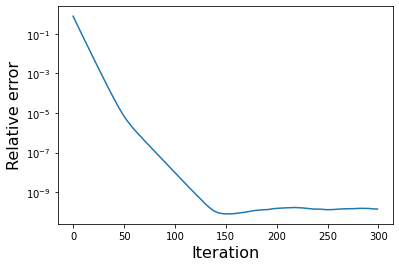

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_avg)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

It can be observed from the above figure that the SVRG with Exact Diffusion can precisely converge to the optimal solution in a stochastic decentralized scenarios. The two segments of the convergence rate demonstrates two bias sources (from stochastic and decentralized optimization) are corrected by SVRG algorithm with Exact Diffusion during the optimization.